<a href="https://colab.research.google.com/github/Gianna17159/dependency-parser/blob/main/%F0%9F%94%AE_Shift_Reduce_Dependency_Parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔮 ➡️ Shift-Reduce Dependency Parser

# Package Imports and Installation Setup

In [ ]:
!pip install torch tqdm numpy evaluate

In [ ]:
import numpy as np
import random
import tqdm
import torch
from evaluate import load as load_metric

from typing import Any
from numpy.typing import NDArray

from google.colab import output
output.enable_custom_widget_manager()

# seeding
random.seed(1460)
np.random.seed(1460)
torch.manual_seed(1460)

# Part 1: Basic Algorithm with Ground-Truth Dummy Oracle

### 1. Download and load the data

We will be using two files for this: `train.conll` and `test.conll`.

In [ ]:
#update FOLDER below!
FOLDER = "/content/drive/My Drive/cs1460/assignment 5"
TRAIN_FILEPATH = f"{FOLDER}/train.conll"
TEST_FILEPATH = f"{FOLDER}/test.conll"

`read_conll` returns a list of dictionaries, where each dictionary encodes a parsed sentence. Each dictionary has a `"words"` key, which maps to a list of words which make up the sentence, and `"heads"` key, which maps to a list of integers, where the value at index `i` is the index of the word that is word `i`'s head. The root word has a head value of `None`.  

So the sentence "1460 is awesome." would have the words `["1460", "is", "awesome", "."]` (yes, the punctuation is included), with heads `[2, 2, None, 2]`. Check out the visual below which illustrates the dependency parse (arrows going out of one word and into another mean that that first word is the head of the second):

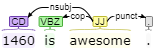

As you can see, "awesome" is the root word, and its head is hence the value `None`. "awesome" is also the head of all of the other words, you can see this since the `"heads"` values corresponding to the other words are all `2`, which is the index of the word "awesome" in the `"words"` list.'

In [ ]:
def read_conll(in_file: str,
               lowercase: bool = False,
               max_example: int | None = None
               ) -> list[dict[str, Any]]:
    """
    Function that reads in a CoNLL file and produces example parses.

    Parameters
    ----------
    in_file : str
        file path to a .conll file
    lowercase : bool
        determines whether to lowercase words in the "words" string
    max_example : int | None
        the maximum number of examples to process, or None to process all

    Returns
    -------
    list[dict[str, Any]]
        a list of examples taken from the .conll file
    """

    examples = []
    with open(in_file) as f:
        word, pos, head, label = [], [], [], []
        for line in f.readlines():
            sp = line.strip().split("\t")
            if len(sp) == 10:
                if "-" not in sp[0]:
                    word.append(sp[1].lower() if lowercase else sp[1])
                    pos.append(sp[4])
                    head.append(int(sp[6]) - 1)
                    label.append(sp[7])
            elif len(word) > 0:
                examples.append({"words": word, "pos": pos, "heads": head, "label": label})
                word, pos, head, label = [], [], [], []
                if (max_example is not None) and (len(examples) == max_example):
                    break
        if len(word) > 0:
            head[head.index(-1)] = None
            examples.append({"words": word, "pos": pos, "heads": head, "label": label})
    return examples

### 2. Ground-truth dummy oracle **
This function takes the current stack, buffer, root word, as well as the full parse (read from the CoNLL), and returns the ground-truth correct action (arc left, arc right, or shift) to be taken by the shift-reduce algorithm.

NOTE: Integers represent predicted actions. This is helpful for the sake of model training and visualization later on.

In [ ]:
def get_ground_truth_oracle(stack: list[int],
                            buf: list[int],
                            ex: dict[str, Any]
                            ) -> int | None:
    """
    Function that retrieves the best possible action (arc left, arc right, or shift)
    for a given stack, buffer, and a labeled example sentence from the CoNLL file.

    Parameters
    ----------
    stack : list[int]
        the shift-reduce stack
    buf : list[int]
        the shift-reduce buffer
    ex : dict[str, Any]
        raw training example dict produced by read_conll()

    Returns
    -------
    int | None: {None, 0, 1, 2}
        action to apply in shift-reduce algorithm

        None -> no actions can be taken
        0 -> arc left
        1 -> arc right
        2 -> shift
    """

    if len(stack) == 1:
        return None if len(buf) == 0 else 2
    elif len(stack) == 2:
        return 1 if len(buf) == 0 else 2

    sf = stack[-1]
    ss = stack[-2]
    hf = ex["heads"][sf]
    hs = ex["heads"][ss]

    if hs == sf:
        return 0
    elif hf == ss and (not any([True for x in buf if ex["heads"][x] == sf])):
        return 1
    else:
        return None if len(buf) == 0 else 2

### 3. `word_to_id`

**Background information about the oracle**

To train a model using supervised learning to create the oracle, we'll break the parsing of an entire sentence down into steps, called _partial parses_. At each step a classifier will have to decide, given some features of a partial parse, whether to arc left, arc right, or shift. I label each partial parse with the correct action (from the CoNLL data), and train the model to execute partial parses as well as possible.

The input to the model is therefore a set of features of the partial parse, from which the correct action is to be predicted. The model will use learned word embeddings to interpret these features, and will classify between three classes (arc left, arc right, and shift). The model's embedding layer will be used to fetch these learned embeddings for words based on their vocabulary index/ID. As such, the model takes some number of integers, each less than the size of the vocabulary, as input.

-------

I first define `word_to_id`, which, when in `is_test=False` mode, both builds a vocabulary as well as returns the IDs of known words; when `is_test=True`, unknown words are not used to expand the vocabulary.

In [ ]:
def word_to_id(word: str, vocab: dict[str, int], is_test: bool = False) -> int:
    """
    Function that converts a string `word` to its corresponding ID in `vocab`.
    If not in testing mode, also adds `word` to vocab.

    Parameters
    ----------
    word : str
        the word in question
    vocab : dict[str, int]
        vocabulary mapping words to their ID
    is_test : bool
        whether to operate in testing or training mode

    Returns
    -------
    int
        the ID of `word`
    """

    if is_test:
        if word in vocab:
            return vocab[word]
        else:
            return vocab["<UNK>"]

    # otherwise, we're doing train:
    if word in vocab:
        if random.randint(0, 100) < 5:
            # randomly mask this word for training example, otherwise <UNK> never trained on
            return vocab["<UNK>"]
        return vocab[word]
    else:
        n = len(vocab)
        vocab[word] = n
        return n

## 4. `apply_action`

In [ ]:
def apply_action(stack: list[int],
                 buf: list[int],
                 arcs: list[tuple[int, int]],
                 action: int
                 ) -> tuple[list[int],
                            list[int],
                            list[tuple[int, int]]]:
    """
    Function that applies `action` to the current state. Modifies `stack`, `buf`, and
    `arcs` accordingly and returns their modified versions. `stack`, `buf`, and `arcs` contain the
    indices of words in an example sentence, where an index of None represents the
    root.

    Parameters
    ----------
    stack : list[int]
        the current shift-reduce stack. stack[-1] is the top of stack, stack[-2] is
        the second item
    buf : list[int]
        the current shift-reduce buffer. buf[0] is the first item in the buffer
    arcs : list[tuple[int, int]]
        the current arcs produced by shift-reduce (of the form (head idx, word idx))
    action : int
        the action we want to apply
        0 -> arc left
        1 -> arc right
        2 -> shift

    Returns
    -------
    tuple[list[int], list[int], list[tuple[int, int]]]
        the updated stack, buffer, and arcs
    """

    if action == 0:
        first = stack.pop(-2)
        arcs.append((stack[-1], first))
    elif action == 1:
        last = stack.pop(-1)
        arcs.append((stack[-1], last))
    elif action == 2:
        stack.append(buf[0])
        buf.pop(0)
    return stack, buf, arcs

### 5. `get_features`
This is a featurization function. It takes in information about the partial parse - the stack, buffer, words in the sentence being parsed, and a vocabulary (as well as an `is_test` flag) - and returns a featurization to be passed to the classifier in order to get an output (the action to be taken).

In [ ]:
def get_features(stack: list[int],
                 buf: list[int],
                 words: list[str],
                 vocab: dict[str, int],
                 is_test: bool = False
                 ) -> list[int]:
    """
    Function that takes in the current state (stack, buffer) and produces a set of
    features to be fed into a classifier. Think about what information our
    classifier would need to know in order to predict an optimal action from the
    current state.
    HINT: you should only need 3 features!

    Parameters
    ----------
    stack : list[int]
        the shift-reduce stack
    buf : list[int]
        the shift-reduce buffer
    words : list[str]
        words in the sentence, in order
    vocab : dict[str, int]
        the vocabulary used to generate the word IDs
    is_test : bool
        whether we are in testing mode

    Returns
    -------
    list[int]
        A list of three integers to be fed into the classifier
        HINT: use word_to_id on the items of the data structures
    """

    if len(stack) == 1:
        if len(buf) == 0:
            return [word_to_id("<ROOT>", vocab, is_test), word_to_id("<NW>", vocab, is_test), word_to_id("<NW>", vocab, is_test)]
        elif len(buf) >= 1:
            return [word_to_id("<ROOT>", vocab, is_test), word_to_id("<NW>", vocab, is_test), word_to_id(words[buf[0]], vocab, is_test)]
    elif len(stack) == 2:
        if len(buf) == 0:
            return [word_to_id(words[stack[-1]], vocab, is_test), word_to_id("<ROOT>", vocab, is_test), word_to_id("<NW>", vocab, is_test)]
        elif len(buf) >= 1:
            return [word_to_id(words[stack[-1]], vocab, is_test), word_to_id("<ROOT>", vocab, is_test), word_to_id(words[buf[0]], vocab, is_test)]
    elif len(stack) >= 3:
        if len(buf) == 0:
            return [word_to_id(words[stack[-1]], vocab, is_test), word_to_id(words[stack[-2]], vocab, is_test), word_to_id("<NW>", vocab, is_test)]
        elif len(buf) >= 1:
            return [word_to_id(words[stack[-1]], vocab, is_test), word_to_id(words[stack[-2]], vocab, is_test), word_to_id(words[buf[0]], vocab, is_test)]

In [ ]:
# Test get features
sentence = "I prefer the morning flight through Denver ."
parse_example = {"words": sentence.split(" "), "heads": [1, None, 4, 4, 1, 6, 1, 1]}
fake_vocab = {"<ROOT>": 0, "<UNK>": 1, "<NW>": 2, "I": 3, "prefer": 4, "the": 5, "morning": 6, "flight": 7, "through": 8, "Denver": 9, ".": 10}

stack = [None]                  # stack initialized with root index
buf = [0, 1, 2, 3, 4, 5, 6, 7]  # buf initialized with word indices
features = get_features(stack, buf, parse_example["words"], fake_vocab, is_test=False)

assert len(features) == 3
print(features)

[0, 2, 3]


### 6. `oracle_shift_reduce` **[TODO]**
This is one of the two implementations of shift-reduce algorithm; in this first case, we know the ground-truth action (rather than using a model that was trained to act as an oracle). For a labeled example, this function applies the algorithm to generate partial parses for training, as well as the correct arcs.

In [ ]:
def oracle_shift_reduce(example: dict[str, Any],
                        vocab: dict[str, int],
                        is_test: bool = False
                        ) -> tuple[list[list[int]],
                                   list[int],
                                   list[tuple[int, int]]]:
    """
    Function that executes the ideal shift-reduce algorithm determined by the ground-truth oracle
    on a single example, and returns a set of features and labels to pass into the classifier.
    This function will be called for every example parse to generate our training
    data.

    Parameters
    ----------
    example : dict[str, Any]
        a training example produced by read_conll
    vocab : dict[str, int]
        the vocabulary
    is_test : bool
        whether the function is being used to generate training or testing data.

    Returns
    -------
    tuple[list[list[int]], list[int], list[tuple[int, int]]]
        featurized states, ground truth actions, and final set of arcs.
    """

    featurized_states = []
    ground_truth_actions = []

    # initialize stack, buffer, and arcs
    stack = [None]
    buf = []
    for i in range(len(example["words"])):
        buf.append(i)
    arcs = []

    while len(stack) > 1 or len(buf) > 0:
        action = get_ground_truth_oracle(stack, buf, example)
        if action is None:
            return featurized_states, ground_truth_actions, arcs
        featurized_states.append(get_features(stack, buf, example["words"], vocab, is_test))
        ground_truth_actions.append(action)
        stack, buf, arcs = apply_action(stack, buf, arcs, action)

    return featurized_states, ground_truth_actions, arcs

# Part 2: Machine-Learned Oracle
Above, you implemented a version of shift-reduce that assumed you had a ground-truth oracle. Of course, in the real world, you won't ever have this! So, in order to run your parser on unseen data, you will need to implement another version of the oracle - this time using machine learning!

### 1. `generate_training_data`
Uses the ground-truth oracle from above to generate training/testing instances (partial parses labeled with the appropriate next action to take) to train the classifier on. This essentially entails applying `oracle_shift_reduce` to every example in the raw data.

In [ ]:
def generate_training_data(raw_data: list[dict[str, Any]],
                           vocab: dict[str, int],
                           is_test: bool = False
                           ) -> tuple[list[list[int]],
                                      list[int]]:
    """
    Function that generates training data and labels from a list of examples
    produced by read_conll().

    Parameters
    ----------
    raw_data : list[dict[str, Any]]
        a list of example parses loaded with read_conll
    vocab : dict[str, int]
        the vocabulary to use
    is_test : bool
        whether to create testing or training data

    Returns
    -------
    tuple[list[list[int]], list[int]]
        a set of featurized states and corresponding ground truth actions
    """

    X, Y = [], []

    for example in raw_data:
        featurized_states, ground_truth_actions, arcs = oracle_shift_reduce(example, vocab, is_test)
        X.extend(featurized_states)
        Y.extend(ground_truth_actions)

    return X, Y

### 2. SRDataset
Since this assignment uses PyTorch modules as the classifiers for the shift-reduce algorithm, I make a `Dataset` child class for the data, such that I can eventually use PyTorch `DataLoader`s during training and evaluation.


In [ ]:
class SRDataset(torch.utils.data.Dataset):
    def __init__(self, X: list[list[int]], Y: list[int]) -> None:
        """
        Function that initializes fields for the dataset.

        Parameters
        ----------
        X : list[list[int]]
            our featurized data from `generate_training_data()`
        Y : list[int]
            one-hot encoded labels corresponding to each entry in X

        Returns
        -------
        None
        """

        self.X = np.zeros((len(X), len(X[0])), dtype="int32")
        self.Y = np.zeros((len(Y), 3), dtype="float32")
        for i, class_num in enumerate(Y):
            self.X[i] = X[i]
            self.Y[i, class_num] = 1

    def __len__(self) -> int:
        """
        Function that returns the number of training examples.

        Parameters
        ----------
        self : refers to the current object

        Returns
        -------
        int
            the number of entries in X
        """
        return len(self.Y)

    def __getitem__(self, idx: int) -> dict[str, NDArray[Any]]:
        """
        Function that defines how to retrieve an entry and a label from the data given
        and index.

        Parameters
        ----------
        idx : int
            the index of an example in X or Y
        Returns
        -------
        dict[str, NDArray[Any]]
            a dictionary defining the example and corresponding label described by
            index `idx`
        """
        return {"inputs": self.X[idx], "targets": self.Y[idx]}

### 3. Training Function

In [ ]:
def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          epochs: int,
          optimizer: torch.optim.Optimizer,
          metric_names: list[str]) -> None:
    """
    Function that trains our classifier.

    Parameters
    ----------
    model : torch.nn.Module
        the classifier we want to train
    dataloader : torch.utils.data.DataLoader
        the dataloader containing our training data
    epochs : int
        number of epochs to train the model
    optimizer : torch.optim.Optimizer
        the optimizer to use for training
    metric_names : list[str]
        list of metric names to compute

    Returns
    -------
    None
    """
    model.train()
    loss_func = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        print(f"epoch {epoch}")
        progress_bar = tqdm.notebook.tqdm(range(len(dataloader)))

        metrics = [load_metric(x) for x in metric_names]

        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)

            loss = loss_func(outputs["output"], outputs["labels"])
            loss.backward()

            predictions = torch.argmax(outputs["output"], dim=1)
            references = torch.argmax(outputs["labels"], dim=-1)

            for metric in metrics:
                metric.add_batch(predictions=predictions, references=references)

            optimizer.step()
            optimizer.zero_grad()
            progress_bar.update(1)

        for metric in metrics:
            print(metric.compute())

### 4. `SRClassifier`

In [ ]:
class SRClassifier(torch.nn.Module):
    def __init__(self, vocab_size: int, num_features: int) -> None:
        """
        Function that initializes fields for this model. This is where you can
        your model's architecture.

        Parameters
        ----------
        vocab_size : int
            the number of words in our vocabulary
        num_features : int
            the number of features for each training example (same as length of the
            list returned by `get_features()`)

        Returns
        -------
        None
        """
        super(SRClassifier, self).__init__()

        # TODO

        self.embedding = torch.nn.Embedding(vocab_size, 128)
        self.linear1 = torch.nn.Linear(num_features * 128, 128)
        self.linear2 = torch.nn.Linear(128, 64)
        self.linear3 = torch.nn.Linear(64, num_features)
        self.relu1 = torch.nn.ReLU()
        self.relu2 = torch.nn.ReLU()
        self.relu3 = torch.nn.ReLU()

    def forward(self,
                inputs: torch.IntTensor,
                targets: torch.IntTensor | None = None
                ) -> dict[str, torch.FloatTensor | torch.IntTensor]: # notice that the arg names need to match SRDataset.__getitem__() keys
        """
        Function that defines the forward pass for this model.

        Parameters
        ----------
        inputs : torch.IntTensor
            a tensor passed into our model. When training/testing, the torch
            dataloader automatically casts our numpy arrays to tensors.
        targets : torch.IntTensor | None
            a tensor representing labels for each training example in `inputs`. If
            not training, this parameter can be None.

        Returns
        -------
        dict[str, torch.FloatTensor | torch.IntTensor]
            a dictionary containing our model's output and corresponding labels.
        """

        #pass inputs (numpy array of word indices/IDs) through classifier

        x = self.embedding(inputs)
        x = x.view(x.size(0), -1)
        x = self.relu1(self.linear1(x))
        x = self.relu2(self.linear2(x))
        outputs = self.relu3(self.linear3(x))

        return {'output': outputs, 'labels': targets}

### 5. Training the classifier
Initialize some required data that will be used in training.

In [ ]:
vocabulary = {"<ROOT>": 0, "<UNK>": 1, "<NW>": 2}

Load the training data using `read_conll`, generate training instances using `generate_training_data` and instantiate a `SRDataset` object with them. Finally, create a `DataLoader` with the `SRDataset` object.

In [ ]:
from google.colab import drive
drive.mount("drive")

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
raw_training_data = read_conll(TRAIN_FILEPATH) # if this fails, scroll back up to Part 1 and update the filepath

X_train, Y_train = generate_training_data(raw_training_data, vocabulary)

train_dataset = SRDataset(X_train, Y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1024)

In [ ]:
# at this point, each partial parse should be a 3-tuple of integers.
print(X_train[:10])
print(Y_train[:10])

[[0, 2, 3], [3, 0, 4], [4, 3, 5], [5, 4, 6], [6, 5, 7], [7, 6, 8], [7, 5, 8], [7, 4, 8], [7, 3, 8], [7, 0, 8]]
[2, 2, 2, 2, 2, 0, 0, 0, 0, 2]


Instantiate our classifier and set up the training hyperparameters and the optimizer.

In [ ]:
# setting up the classifier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SRClassifier(len(vocabulary), 3) # instantiate classifier
print(model)

epochs = 4

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3)

model.to(device)

metrics = ["accuracy"]

train(model, train_dataloader, epochs, optimizer, metrics)

SRClassifier(
  (embedding): Embedding(44392, 128)
  (linear1): Linear(in_features=384, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=3, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
)
epoch 0


  0%|          | 0/1855 [00:00<?, ?it/s]

{'accuracy': 0.8358743539956449}
epoch 1


  0%|          | 0/1855 [00:00<?, ?it/s]

{'accuracy': 0.8830253010475063}
epoch 2


  0%|          | 0/1855 [00:00<?, ?it/s]

{'accuracy': 0.899669258405954}
epoch 3


  0%|          | 0/1855 [00:00<?, ?it/s]

{'accuracy': 0.9120117849726856}


### 6. Evaluating the classifier
I evaluate the classifer to get an idea of its accuracy before using it as an oracle in the shift-reduce algorithm. First, I load the testing data and generate the labeled partial parses for testing, after which I instantiate `SRDataset` and `DataLoader` objects similarly to when training.

In [ ]:
test_data = read_conll(TEST_FILEPATH)

X_test, Y_test = generate_training_data(test_data, vocabulary, is_test=True) # is_test is true here!

test_dataset = SRDataset(X_test, Y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=256)

In [ ]:
def evaluate(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             metric_names: list[str]
             ) -> None:
    """
    Function that evaluates a trained model.

    Parameters
    ----------
    model : torch.nn.Module
        the model to be evaluated
    dataloader : torch.utils.data.DataLoader
        the dataloader containing our testing data
    metric_names : list[str]
        a list of metric names to compute

    Returns
    -------
    None
    """
    model.eval()
    metrics = [load_metric(metric) for metric in metric_names]

    print("evaluation: ")
    progress_bar = tqdm.notebook.tqdm(range(len(dataloader)))

    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        predictions = torch.argmax(outputs["output"], dim=1)
        references = torch.argmax(outputs["labels"], dim=-1)

        for metric in metrics:
            metric.add_batch(predictions=predictions, references=references)

        progress_bar.update(1)

    for metric in metrics:
        print(metric.compute())

Evaluate the model to assess its performance in correctly classifying partial parses.

In [ ]:
metrics = ["accuracy"]
evaluate(model, test_dataloader, metrics)

evaluation: 


  0%|          | 0/443 [00:00<?, ?it/s]

{'accuracy': 0.8960767357311779}


# Part 3: Evaluation and Visualization


### 1. `is_possible`
`is_possible` returns whether an action (arc or shift) is possible given the current stack and buffer. This will be used in `get_action` (see below) to start training an oracle using machine learning.

In [ ]:
def is_possible(action: int, stack: list[int], buf: list[int]) -> bool:
    """
    Function that determines if a given action is possible given the current stack
    and buffer state. Remember that `stack` and `buf` contain the indices of words in
    an example sentence, where an index of None represents the root.

    Think carefully about this function; it is likely to be a source of errors.
    Work through the example in the slides and try to replicate that logic here.
    Be particularly careful with the root (None). Can anything be the head of
    root? Should we ever perform an arc with the root while there are still words
    in the buffer?

    Remember that at the beginning of the shift-reduce algorithm,
    stack and buf will look like:
        stack = [None]
        buf = [0, 1, 2, ...]

    Parameters
    ----------
    action : int
        the action we want to know is possible
        0 -> arc left
        1 -> arc right
        2 -> shift
    stack : list[int]
        the shift-reduce stack
    buf : list[int]
        the shift-reduce buffer

    Returns
    -------
    bool
        whether or not the given action is possible
    """

    if action == 2:
      if len(buf) == 0:
        return False
      else:
        return True
    elif action == 0:
      if len(stack) == 1:
        return False
      elif len(stack) == 2:
        return False
      else:
        return True
    elif action == 1:
      if len(stack) == 1:
        return False
      elif stack[-2] == None:
        if len(buf) == 0:
          return True
        else:
          return False
      else:
        return True

### 2. `get_action`

This function takes in the classifier's prediction (in the form of a tensor) and outputs the corresponding action.

In [ ]:
def get_action(pred: torch.DoubleTensor,
               stack: list[int],
               buf: list[int]
               ) -> int | None:
    """
    Function that takes a prediction (Tensor) and finds the highest probability
    action that is possible.

    Parameters
    ----------
    pred : torch.DoubleTensor
        our classifier's prediction, the "output" field of a torch.nn.Module (such
        as our model)
    stack : list[int]
        the shift-reduce stack
    buf : list[int]
        the shift-reduce buffer

    Returns
    -------
    int | None: {None, 0, 1, 2}
        the predicted action.
        None -> predicted action is not possible
        0 -> arc left
        1 -> arc right
        2 -> shift
    """

    action = torch.argmax(pred)
    if is_possible(action, stack, buf):
      return action
    else:
      return None

### 3. `model_shift_reduce`
Here, I define a version of shift-reduce that consults an SRClassifier, rather than the oracle from Part 1, in order to determine which actions to apply.

In [ ]:
def model_shift_reduce(model: torch.nn.Module,
                       example: dict[str, Any],
                       vocab: dict[str, int]
                       ) -> list[tuple[int, int]]:
    """
    Function that uses our trained classifier to execute the shift-reduce algorithm
    and returns the final list of arcs.
    NOTE: You will have to cast the output of `get_features()` to a tensor and
    load it onto the GPU. You can do this using `torch.tensor(...).to(device)`
    or `torch.tensor(..., device=device)`. Note that `device` was defined a few
    cells up, when we instantiated our model.

    Parameters
    ----------
    model : torch.nn.Module
        our trained classifier to use for shift-reduce
    example : dict[str, Any]
        a training example produced by read_conll
    vocab : dict[str, int]
        our vocabulary

    Returns
    -------
    list[tuple[int, int]]
        the arcs of the dependency parse tree
    """

    # init stack, buf, arcs
    stack = [None]
    buf = []
    for i in range(len(example["words"])):
      buf.append(i)
    arcs = []

    while len(buf) > 0 or len(stack) > 1:
      features = get_features(stack, buf, example["words"], vocab, is_test=True)
      features = torch.tensor(features).to(device)
      features = features.unsqueeze(0)
      pred = model(features)["output"]
      action = get_action(pred, stack, buf)

      if action != None:
        stack, buf, arcs = apply_action(stack, buf, arcs, action)
      else:
        break
    return arcs

### 4. `evaluate_UAS`
Now that we can directly compare the true parse to the model's parse, we can tackle evaluating the UAS. To evaluate UAS, we first compute both the correct and predicted parses for each sentence in the testing set and then find the number of arcs in common divided by the number of total arcs. Then, we average these scores across all sentences in the testing set, and output the result as the UAS of the model on the testing set.

$$n: \text{the total number of example parses}$$
$$M_i: \text{the set of our model's predicted arcs for example }i$$
$$O_i: \text{the set of the oracle's predicted arcs for example }i$$
$$\text{UAS} = \frac{1}{n} \sum_{i=1}^n \frac{|M_i \cap O_i|}{|O_i|}$$

In [ ]:
def evaluate_UAS(model: torch.nn.Module,
                 test_examples: list[dict[str, Any]],
                 vocab: dict[str, int]
                 ) -> float:
    """
    Function that calculates UAS.

    Parameters
    ----------
    model : torch.nn.Module
        our trained classifier
    test_examples : list[dict[str, Any]]
        test examples loaded with read_conll
    vocab : dict[str, int]
        our word2id vocabulary

    Returns
    -------
    float
        UAS of the classifier on test_examples
    """

    total_correct = 0
    total_arcs = 0
    for example in test_examples:
      _, _, true_arcs = oracle_shift_reduce(example, vocab, is_test=True)
      model_arcs = model_shift_reduce(model, example, vocab)
      total_correct += len(set(true_arcs) & set(model_arcs))
      total_arcs += len(true_arcs)
    return total_correct / total_arcs


#### Baseline UAS
The baseline model should output something of the same format as the `SRClassifier`, except it just outputs a tensor with randomly ordered values.

In [ ]:
class SRBaseline(torch.nn.Module):
    def __init__(self) -> None:
        super(SRBaseline, self).__init__()

    def forward(self, inputs: Any) -> dict[str, torch.Tensor]:
        return {"output": torch.randperm(3)[None, :]}

### 5. Final Scoring
Evaluate the baseline UAS and compare it to that of the trained model.


In [ ]:
model_uas = evaluate_UAS(model, test_data, vocabulary)
baseline_model = SRClassifier(len(vocabulary), 3)
baseline_uas = evaluate_UAS(baseline_model, test_data, vocabulary)
print(f"Model UAS: {model_uas}, baseline: {baseline_uas}")

Model UAS: 0.6885063559322034, baseline: 0.003972457627118644


In [ ]:
import spacy
from spacy import displacy
from spacy.displacy.render import DependencyRenderer
from IPython.core.display import display, HTML

def reformat_dep(arcs: list[tuple[int, int]],
                 words: list[str]
                 ) -> tuple[list[str], list[int]]:
    """
    Function that takes in a set of arcs and produces a list of heads,
    in the same format we described at the beginning.

    Parameters
    ----------
    arcs : list[tuple[int, int]]
        a list of arcs returned by model_shift_reduce
    words : list[str]
        a list of words from a testing example

    Returns
    -------
    tuple[list[str], list[int]]
        the words parameters and the list of heads
    """
    heads = list(range(len(words)))
    for arc in arcs:
        heads[arc[1]] = arc[0]
    return words, heads

def parse_for_displacy(doc: list[str], heads: list[int]) -> dict[str, Any]:
    """
    Function that takes in a sentence and a list of heads and reformats them into
    something that can be rendered using displacy.

    Parameters
    ----------
    doc : list[str]
        a list of words in a sentence
    heads : list[int]
        a list of indices indexing `doc` that represent the head of each word

    Returns
    -------
    dict[str, Any]
        the parsed sentence in a format friendly to displacy
    """
    # doc = ["word1", "word2", ...]
    # heads = [idx_of_head_of_word1, idx_of_head_of_word2, ...]
    settings = {
        "lang": "en",
        "direction": "ltr",
    }
    words = [
        {
            "text": w, # w.text,
            "tag": "", # w.tag_ if fine_grained else w.pos_,
            "lemma": w # w.lemma_ if add_lemma else None,
        }
        for w in doc
    ]
    arcs = []
    for i,word in enumerate(doc):
        if heads[i] == None:
            continue
        if i < heads[i]:
            arcs.append({"start": i, "end": heads[i], "label": '', "dir": "left"})
        elif i > heads[i]:
            arcs.append({
                "start": heads[i],
                "end": i,
                "label": "",
                "dir": "right",
              })
    return {"words": words, "arcs": arcs, "settings": settings}

def display_parse(arcs: list[tuple[int, int]], words: list[str]) -> None:
    """
    Function that renders and displays a parsed sentence.

    Parameters
    ----------
    arcs : list[tuple[int, int]]
        the final set of arcs returned by our shift-reduce algorithm
    words : list[str]
        the words that `arcs` connects

    Returns
    -------
    None
    """
    parsed = [parse_for_displacy(*reformat_dep(arcs, words))]
    renderer = DependencyRenderer()
    html = renderer.render(parsed, page=False, minify=False).strip()
    display(HTML('<span class="tex2jax_ignore">{}</span>'.format(html)))

Below is an example of comparing the true parse and the model's parse, where we try to parse the sentence "I prefer the morning flight through Denver.". Note that punctuation is treated as its own token here.

Here is a brief summary of how you need to format punctuation and contractions in your own examples **such that they're in the same format** as the training/testing data we used previously:

`"weren't" -> ["were", "n't"]`

`"Stock Market's" -> ["Stock", "Market", "'s"]`

`["'quoted text'"] -> ["``", "quoted", "text", "''"]`

`["22%"] -> ["22", "%"]`

`["$15"] -> ["$", "15"]`

Feel free to download `train.conll` or `test.conll` and take a peek at how the examples are tokenized.

Additionally, we didn't do any lowercasing on the dataset, since it actually slightly harms performance on this task (think about why it might!). Therefore, you too shouldn't do lowercasing when trying out your own sentences (see that "Denver" stays capitalized).

In [ ]:
example = {"words": "I prefer the morning flight through Denver .".split(" "), "heads": [1, None, 4, 4, 1, 6, 4, 1]}

model_arcs = model_shift_reduce(model, example, vocabulary) # get the model's parse
_, _, true_arcs = oracle_shift_reduce(example, vocabulary, is_test=True) # get the true parse

print("Predicted parse:")
display_parse(model_arcs, example["words"])
print("Actual parse:")
display_parse(true_arcs, example["words"])

Predicted parse:


Actual parse:


Last Updated: 7 Nov 2024